In [130]:
import os
import sys
while not os.getcwd().endswith('ml'):
    os.chdir('..')
sys.path.insert(0, os.getcwd())

/Users/skrrydg/Desktop/Code/ml/ml_helpers/common_helpers.py:18: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(keys) > 0, "keys must not be empty")


In [131]:
import math
import copy
import cv2
import pandas as pd
import numpy as np
import random
from shutil import copyfile
from pathlib import Path
from matplotlib import pyplot as plt

from kaggle_problems.rosneft_proppant.helpers import *

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from ml_helpers.image_helpers import display_images
from ml_helpers.common_helpers import display_history_metrics

from kaggle_problems.rosneft_proppant.common import *
from kaggle_problems.rosneft_proppant.RPCC_metric_utils_for_participants import fraction_sievs
from sklearn.model_selection import train_test_split
import pickle


In [132]:
train = pd.read_csv("{}/RPCC_labels.csv".format(DATA_DIR))
train.describe()

,ImageId,6,7,8,10,12,14,16,18,20,...,35,40,45,50,60,70,80,100,pan,prop_count
count,790.000000,756.0,756.0,756.0,756.0,756.0,756.0,756.000000,756.000000,756.000000,...,756.000000,756.000000,756.000000,756.000000,756.0,756.0,756.0,756.0,756.0,64.000000
mean,395.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.011115,0.325205,0.376608,...,0.009513,0.033514,0.000036,0.000072,0.0,0.0,0.0,0.0,0.0,1868.812500
std,228.197648,0.0,0.0,0.0,0.0,0.0,0.0,0.008205,0.235431,0.233366,...,0.030045,0.073941,0.000495,0.000363,0.0,0.0,0.0,0.0,0.0,718.401883
min,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.006100,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,688.000000
25%,198.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.005146,0.008131,0.090836,...,0.000000,0.000300,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1204.750000
50%,395.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,0.370200,0.435100,...,0.000000,0.000600,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1955.500000
75%,592.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.015650,0.486200,0.563200,...,0.000000,0.005600,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,2487.000000
max,790.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.041200,0.844800,0.825500,...,0.187500,0.270995,0.007800,0.005100,0.0,0.0,0.0,0.0,0.0,3029.000000


In [133]:
fractions = train.fraction.unique()
fractions = fractions[:-1] # delete nana
print(fractions)

['20/40' '20/40_pdcpd_bash_lab' '16/20']


In [141]:
train[train.fraction == '20/40']

,ImageId,6,7,8,10,12,14,16,18,20,...,50,60,70,80,100,pan,prop_count,fraction,filename,y
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0525,...,0.0000,0.0,0.0,0.0,0.0,0.0,NaN,20/40,1.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052..."
22,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0474,...,0.0015,0.0,0.0,0.0,0.0,0.0,NaN,20/40,23.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.047..."
26,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0156,...,0.0005,0.0,0.0,0.0,0.0,0.0,NaN,20/40,27.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.015..."
44,45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0145,...,0.0007,0.0,0.0,0.0,0.0,0.0,NaN,20/40,45.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.014..."
57,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0545,...,0.0002,0.0,0.0,0.0,0.0,0.0,NaN,20/40,58.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.054..."
60,61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0372,...,0.0006,0.0,0.0,0.0,0.0,0.0,NaN,20/40,61.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.037..."
63,64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0418,...,0.0006,0.0,0.0,0.0,0.0,0.0,NaN,20/40,64.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041..."
69,70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0415,...,0.0007,0.0,0.0,0.0,0.0,0.0,NaN,20/40,70.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041..."
80,81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0473,...,0.0002,0.0,0.0,0.0,0.0,0.0,NaN,20/40,81.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.047..."
82,83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0145,...,0.0007,0.0,0.0,0.0,0.0,0.0,NaN,20/40,83.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.014..."


In [134]:
for i in bins:
    train = train[~train[i].isnull()]

train["filename"] = train['ImageId'].astype(str) + '.jpg'

In [135]:
train['y'] = train.apply(lambda x: np.array([x[i] for i in bins]), axis=1)

### Model

In [50]:
class BinsExtraction(Model):
    def __init__(self, fraction):
        super(BinsExtraction, self).__init__()
        self.FilterSize1 = 32
        self.FilterSize2 = 16
        self.FilterSize3 = 8
        
        self.model_layers = [
            tf.keras.layers.Conv2D(filters=self.FilterSize1, kernel_size=(5, 5), strides=(5, 5)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
            tf.keras.layers.Dropout(rate=0.3),

            tf.keras.layers.Conv2D(filters=self.FilterSize2, kernel_size=(3, 3), strides=(3, 3)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
            tf.keras.layers.Dropout(rate=0.3),
            
            tf.keras.layers.Conv2D(filters=self.FilterSize3, kernel_size=(3, 3), strides=(3, 3)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
            tf.keras.layers.Dropout(rate=0.3),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(10, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(rate=0.5),
            tf.keras.layers.Dense(len(fraction_sievs[fraction]['all']), activation='softmax'),
        ]

    def call(self, x, *args, **kwargs):
        for model_layer in self.model_layers:
            x = model_layer(x, *args, **kwargs)
        return x

#### Train Input Generator

In [136]:
def get_train_val_datagen(train, fraction, train_size=0.8):
    train_fraction = train[train['fraction'] == fraction]
    
    train_fraction, val_fraction = train_test_split(train_fraction, train_size=train_size, random_state=123)
    
    bins_fraction = fraction_sievs[fraction]['all']
    
    datagen = ImageDataGenerator()

    train_generator = datagen.flow_from_dataframe(
            train_fraction.sample(n=int(len(train_fraction) * DF_RATE)),
            directory=TRAIN_DIR,
            x_col='filename', 
            y_col=bins_fraction,
            target_size=TARGET_SHAPE,
            batch_size=16,
            class_mode='other',
    )
    
    val_generator = datagen.flow_from_dataframe(
        val_fraction.sample(n=int(len(val_fraction) * DF_RATE)),
        directory=TRAIN_DIR,
        x_col='filename', 
        y_col=bins_fraction,
        target_size=TARGET_SHAPE,
        batch_size=16,
        class_mode='other')
    return train_generator, val_generator

#### Input generator checking

Found 70 validated image filenames.
Found 18 validated image filenames.


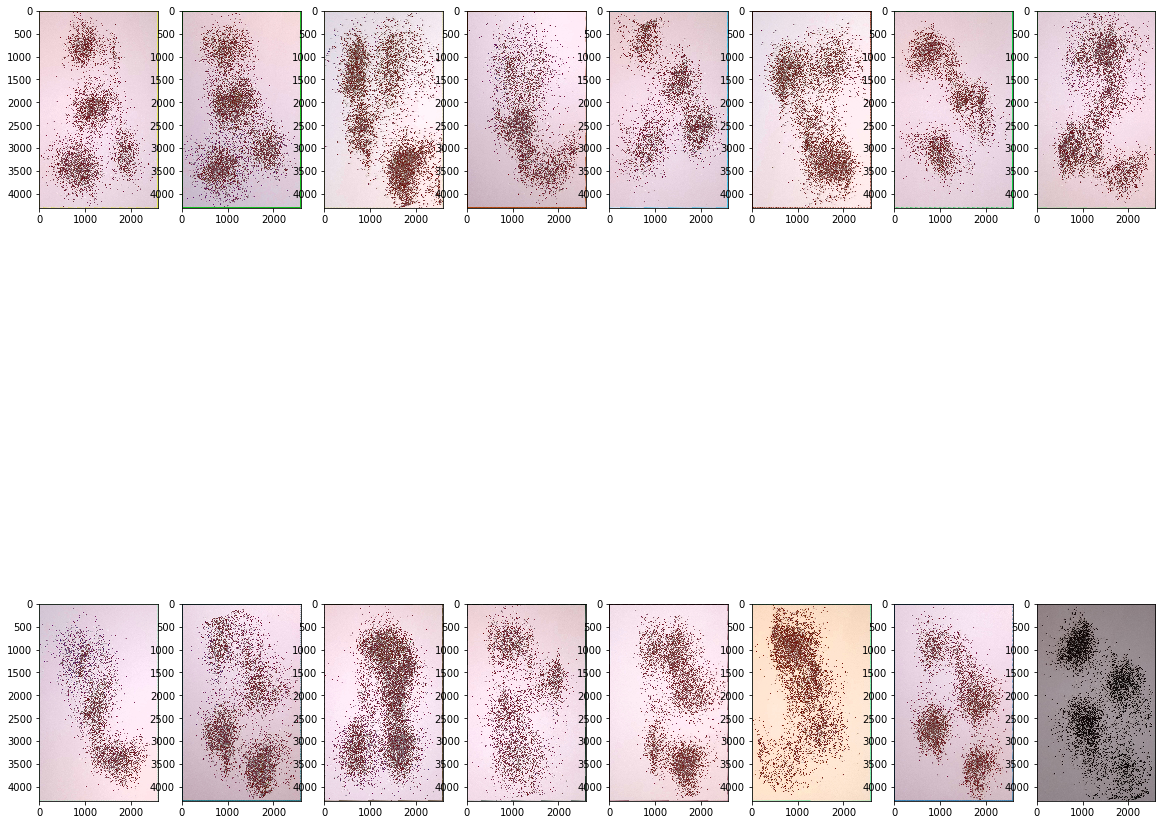

Found 70 validated image filenames.
Found 18 validated image filenames.


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/skrrydg/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-140-105491d98fc4>", line 3, in <module>
    display_images(img.astype(int), 8)
  File "/Users/skrrydg/Desktop/Code/ml/ml_helpers/image_helpers.py", line 17, in display_images
    plt.show()
  File "/Users/skrrydg/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py", line 254, in show
    return _show(*args, **kw)
  File "/Users/skrrydg/anaconda3/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py", line 39, in show
    metadata=_fetch_figure_metadata(figure_manager.canvas.figure)
  File "/Users/skrrydg/anaconda3/lib/python3.7/site-packages/IPython/core/display.py", line 304, in display
    format_dict, md_dict = format(obj, include=include, exclude=exclude)
  File "/Users/skrrydg/anaconda3/lib/python3.7/site-packages/IPython/core/formatters.p

KeyboardInterrupt: 

In [140]:
for i in range(5):
    img, labels = get_train_val_datagen(train, '20/40')[0].next()
    display_images(img.astype(int), 8)

In [53]:
print(labels)

[[0.000e+00 2.400e-02 5.404e-01 3.853e-01 3.650e-02 1.320e-02 8.000e-04]
 [0.000e+00 1.900e-02 4.996e-01 3.333e-01 1.323e-01 1.570e-02 3.000e-04]
 [0.000e+00 3.720e-02 7.123e-01 2.044e-01 3.470e-02 1.090e-02 6.000e-04]
 [0.000e+00 4.420e-02 4.879e-01 3.193e-01 1.298e-01 1.860e-02 3.000e-04]
 [0.000e+00 4.180e-02 4.846e-01 3.981e-01 6.350e-02 1.150e-02 6.000e-04]
 [0.000e+00 3.810e-02 6.140e-01 3.045e-01 3.760e-02 5.600e-03 4.000e-04]
 [0.000e+00 6.100e-03 6.225e-01 2.401e-01 1.223e-01 8.800e-03 3.000e-04]
 [0.000e+00 4.150e-02 4.189e-01 4.549e-01 6.750e-02 1.660e-02 7.000e-04]
 [0.000e+00 6.100e-03 6.225e-01 2.401e-01 1.223e-01 8.800e-03 3.000e-04]
 [0.000e+00 4.180e-02 4.846e-01 3.981e-01 6.350e-02 1.150e-02 6.000e-04]
 [0.000e+00 5.450e-02 5.662e-01 2.925e-01 7.980e-02 7.000e-03 2.000e-04]
 [0.000e+00 1.450e-02 4.501e-01 4.302e-01 1.033e-01 1.300e-03 7.000e-04]
 [0.000e+00 3.720e-02 7.123e-01 2.044e-01 3.470e-02 1.090e-02 6.000e-04]
 [0.000e+00 3.810e-02 6.140e-01 3.045e-01 3.760e-02

#### Callbacks

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

earlystop = EarlyStopping(patience=10)

callbacks = [earlystop, learning_rate_reduction]

In [11]:
def metric(true, predicted):
    return tf.keras.backend.mean(tf.math.reduce_sum((true - predicted) ** 2 / (true + predicted), axis=1))

In [14]:
fractions = fractions[0:1]
for fraction, i in zip(fractions, range(len(fractions))):
    print(fraction)
    model = BinsExtraction(fraction)
    model.compile(
        loss=metric,
        optimizer='rmsprop',
        metrics=['mse']
    )

    train_datagen, val_datagen = get_train_val_datagen(train, fraction)

    history = model.fit(
        x=train_datagen,
        epochs=50,
        validation_data=val_datagen,
        callbacks=callbacks
    )
    
    with open(MODEL_DIR + "/history_model_benchmark_{}.pickle".format(i), 'wb') as f:
        pickle.dump(history.history, f)
        
    model.save(MODEL_DIR + "/model_benchmark_{}".format(i))

20/40
Found 70 validated image filenames.
Found 18 validated image filenames.
  ...
    to  
  ['...']
Train for 5 steps, validate for 2 steps
Epoch 1/30
5/5 [==============================] - 90s 18s/step - loss: 1.0186 - mse: 0.0693 - val_loss: 1.0724 - val_mse: 0.1121
Epoch 2/30
5/5 [==============================] - 83s 17s/step - loss: 0.9849 - mse: 0.0636 - val_loss: 1.0738 - val_mse: 0.1147
Epoch 3/30
4/5 [=======================>......] - ETA: 18s - loss: 1.0579 - mse: 0.0710
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
5/5 [==============================] - 96s 19s/step - loss: 1.0581 - mse: 0.0715 - val_loss: 1.0744 - val_mse: 0.1159
Epoch 4/30
5/5 [==============================] - 83s 17s/step - loss: 0.9628 - mse: 0.0630 - val_loss: 1.0744 - val_mse: 0.1159
Epoch 5/30
4/5 [=======================>......] - ETA: 17s - loss: 0.9505 - mse: 0.0616
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
5/5 [===========

In [123]:
def get_bins_metric(predicted, true):
    return 0.5 * np.sum((predicted - true) ** 2 / (predicted + true)) / predicted.shape[0]

def get_bins_metric_by_image(predicted, true):
    return np.sum(0.5 * (predicted - true) ** 2 / (predicted + true), axis=1)

def get_bins_metric_by_bins(predicted, true):
    return np.sum(0.5 * (predicted - true) ** 2 / (predicted + true), axis=0)

In [124]:
print("Total bin loss: {}".format(get_bins_metric(predicted_labels, all_labels)))

Total bin loss: 0.4532800921378052


/Users/skrrydg/Desktop/Code/ml/ml_helpers/common_helpers.py:17: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  print(keys)


20/40--------------------------------------------------
20/40--------------------------------------------------
Found 70 validated image filenames.
Found 18 validated image filenames.


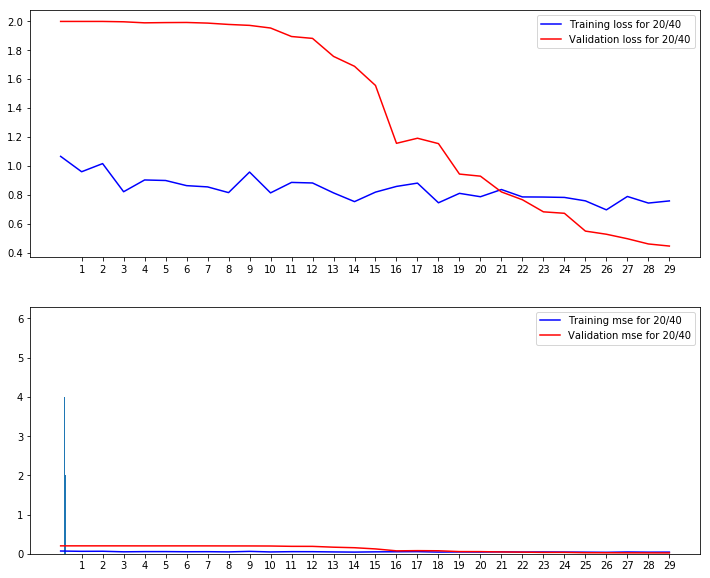

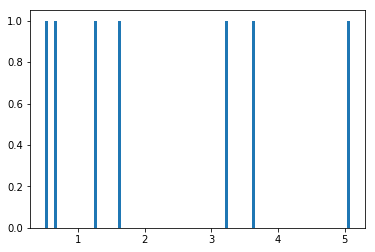

--------------------------------------------------
20/40_pdcpd_bash_lab--------------------------------------------------
20/40_pdcpd_bash_lab--------------------------------------------------
Found 95 validated image filenames.
Found 24 validated image filenames.


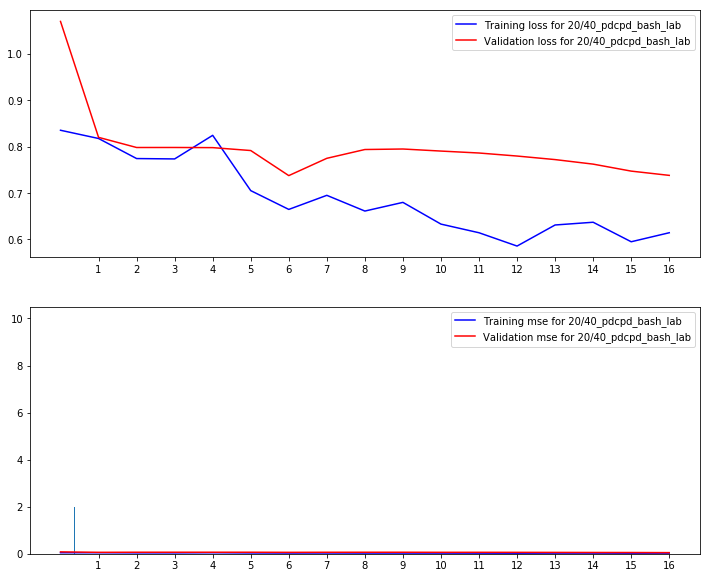

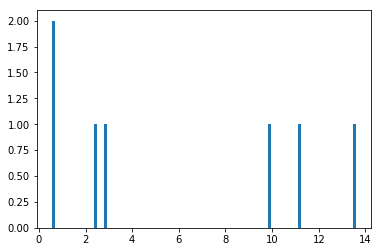

--------------------------------------------------
16/20--------------------------------------------------
16/20--------------------------------------------------
Found 438 validated image filenames.
Found 110 validated image filenames.


/Users/skrrydg/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


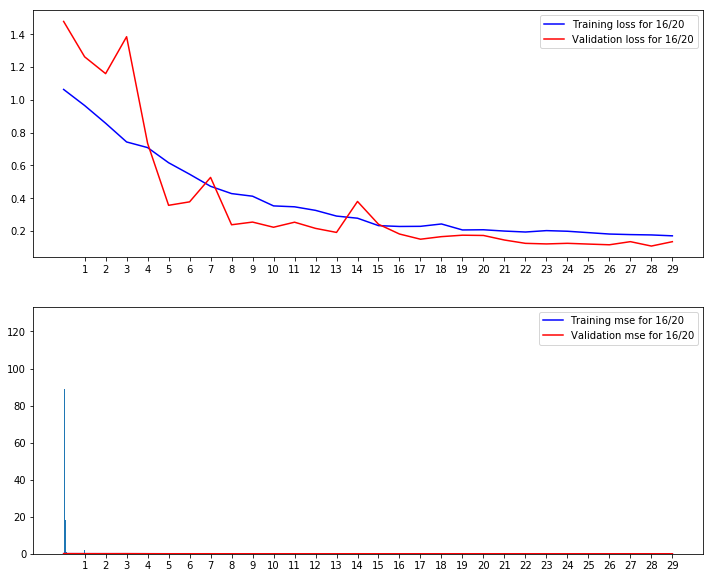

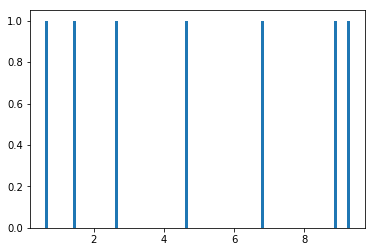

--------------------------------------------------


In [129]:

for fraction, i in zip(fractions, range(len(fractions))):
    print(fraction + "-" * 50)
    from keras.utils.generic_utils import get_custom_objects

    get_custom_objects().update({'metric': metric})

    with open(MODEL_DIR + "/history_model_benchmark_{}.pickle".format(i), 'rb') as f:
        history = pickle.load(f)

    model = tf.keras.models.load_model(MODEL_DIR + "/model_benchmark_{}".format(i), 
                                       compile=False)
    model.compile(
        loss=metric,
        optimizer='rmsprop',
        metrics=['mse']
    )                                                                               

    display_history_metrics(history, fraction)
    print(fraction + '-' * 50)
    
    train_datagen = get_train_val_datagen(train, fraction)[0]

    predicted_labels = []
    all_labels = []
    train_fraction = train[train['fraction'] == fraction]

    for i in range(int(train_fraction.shape[0]) // 16):
        imgs, labels = train_datagen.next()
        predicted_labels.extend(model.predict(imgs))
        all_labels.extend(labels)
    predicted_labels = np.array(predicted_labels)
    all_labels = np.array(all_labels)

    losses_by_img = get_bins_metric_by_image(predicted_labels, all_labels)
    plt.hist(losses_by_img, bins=100)
    plt.show()

    losses_by_bins = get_bins_metric_by_bins(predicted_labels, all_labels)
    plt.hist(losses_by_bins, bins=100)
    plt.show()
    print("-" * 50)

In [79]:
!jupyter nbconvert --to script kaggle_problems/rosneft_proppant/cnn_try.ipynb

[NbConvertApp] Converting notebook kaggle_problems/rosneft_proppant/cnn_try.ipynb to script
[NbConvertApp] Writing 5784 bytes to kaggle_problems/rosneft_proppant/cnn_try.py
